In [1]:
import numpy as np
import xgboost
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GroupShuffleSplit
import pickle
from skopt import BayesSearchCV

# Add in another model from a different framework and test via nested cross validation

In [2]:
#import data
dataset = np.loadtxt('C:\\Users\\lskus\\OneDrive\\Documents\\Past Code and Misc Files\\BE562\\Project\\pd_speech_features.csv',delimiter = ",",skiprows = 2)

print(dataset.shape)

X = dataset[:,1:753]
Y = dataset[:,754]
groups = dataset[:,0]

# group shuffle split to split data in to train and test
# model an independent dataset
splitter = GroupShuffleSplit(test_size = 0.2, n_splits = 1, random_state = 42)
for i, (train_index, test_index) in enumerate(splitter.split(X,Y, groups)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, group={groups[train_index]}")
    print(f"  Test:  index={test_index}, group={groups[test_index]}")
    
    Xtr = X[train_index]
    Ytr = Y[train_index]
    Xt = X[test_index]
    Yt = Y[test_index]
    grouptr = groups[train_index]
    groupt = groups[test_index]

model = xgboost.XGBClassifier(objective="binary:logistic")

(756, 755)
Fold 0:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  21  22  23  24  25  26  33  34  35  36  37  38  39  40  41  42  43  44
  51  52  53  60  61  62  63  64  65  66  67  68  69  70  71  78  79  80
  81  82  83  84  85  86  87  88  89  93  94  95  96  97  98 102 103 104
 105 106 107 108 109 110 111 112 113 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 207 208 209 210 211 212
 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230
 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 249 250 251
 252 253 254 255 256 257 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 291 292 293
 294 295 296 297 

In [3]:
cv_outer = LeaveOneGroupOut() #cross validation for outer loop

outer_results = list() # list of accuracies
fimp = [[None for _ in range(752)] for _ in range(252)] # list of feature importances

In [4]:
#Bayesian Optimization, create boundary dict with all param ranges we want to test
pbounds = {
    "learning_rate": (0.01, 1.0),
    "n_estimators": (100, 1000),
    "max_depth": (3,10),
    "subsample": (0.1, 1.0),  # Change for big datasets
    "colsample_bytree": (0.1, 1.0),  # Change for datasets with lots of features
    "gamma": (0, 5),
    "reg_lambda": (0, 10),
    "scale_pos_weight": (1, 5),
    "colsample_bylevel": (0.2, 0.8),
    "colsample_bynode": (0.2, 0.8),
}

In [5]:
#perform nested cross validation to see how well the model will generalize
#couldn't use gridsearch due to compute times
#Bayesian optimization to find best hyperparams

import pandas as pd

for train_ix, test_ix in cv_outer.split(Xtr,Ytr,grouptr):
    #count = 0
    # split data
    X_train, X_test = Xtr[train_ix, :], Xtr[test_ix, :]
    y_train, y_test = Ytr[train_ix], Ytr[test_ix]

    # bayesian optimization in one line
    search = BayesSearchCV(estimator=model, search_spaces=pbounds, n_jobs=-1, cv=3)
    
    #fit bayes search
    result = search.fit(X_train, y_train)
    #take best params from the fit
    best_model = result.best_estimator_
    # evaluate model on the hold out dataset
    best_model.fit(X_train, y_train)
    yhat = best_model.predict(X_test) # use model with best params for each trial
    # evaluate the model
    acc = accuracy_score(y_test, yhat)
    # store the result
    outer_results.append(acc)
    
    #count = count + 1
    # report progress
    print('>acc=%.3f, cfg=%s' % (acc, result.best_params_))

# summarize the estimated performance of the model
print('Accuracy: %.3f (%.3f)' % (np.mean(outer_results), np.std(outer_results)))

>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.7908642300103739), ('colsample_bynode', 0.43744639157439497), ('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 10), ('n_estimators', 984), ('reg_lambda', 9), ('scale_pos_weight', 2), ('subsample', 0.8785488760479083)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.6561519393559642), ('colsample_bytree', 0.4218179486114484), ('gamma', 0), ('learning_rate', 0.0629734439309889), ('max_depth', 7), ('n_estimators', 1000), ('reg_lambda', 8), ('scale_pos_weight', 5), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.4719908248381379), ('colsample_bynode', 0.33831931506853113), ('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 7), ('n_estimators', 1000), ('reg_lambda', 2), ('scale_pos_weight', 3), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.2), ('colsample_bynode', 0.8), ('colsample_bytree', 0.7

>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.5473774697852622), ('colsample_bytree', 0.1497684458652654), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 10), ('n_estimators', 1000), ('reg_lambda', 5), ('scale_pos_weight', 3), ('subsample', 0.7970399977411542)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.2), ('colsample_bynode', 0.2), ('colsample_bytree', 1.0), ('gamma', 2), ('learning_rate', 0.15896010116682388), ('max_depth', 7), ('n_estimators', 1000), ('reg_lambda', 9), ('scale_pos_weight', 2), ('subsample', 1.0)])
>acc=0.000, cfg=OrderedDict([('colsample_bylevel', 0.20487179651251775), ('colsample_bynode', 0.8), ('colsample_bytree', 0.3273270893609489), ('gamma', 0), ('learning_rate', 0.43374935587316316), ('max_depth', 10), ('n_estimators', 558), ('reg_lambda', 9), ('scale_pos_weight', 3), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.4743952627353716), ('colsample_bynode', 0.6276781441451735), ('colsam

>acc=0.000, cfg=OrderedDict([('colsample_bylevel', 0.24883882159456094), ('colsample_bynode', 0.36750026827196197), ('colsample_bytree', 0.6879442455395269), ('gamma', 4), ('learning_rate', 0.13925431070437774), ('max_depth', 7), ('n_estimators', 970), ('reg_lambda', 3), ('scale_pos_weight', 3), ('subsample', 0.9385144165203033)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.48525859734224613), ('colsample_bynode', 0.6337986463579595), ('colsample_bytree', 0.802584078328353), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 4), ('n_estimators', 1000), ('reg_lambda', 8), ('scale_pos_weight', 1), ('subsample', 1.0)])
>acc=0.000, cfg=OrderedDict([('colsample_bylevel', 0.5875416227392792), ('colsample_bynode', 0.274247767825687), ('colsample_bytree', 0.16202297197908316), ('gamma', 0), ('learning_rate', 0.10204371614898114), ('max_depth', 6), ('n_estimators', 1000), ('reg_lambda', 10), ('scale_pos_weight', 4), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_byleve

>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.41030087411092353), ('colsample_bynode', 0.8), ('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.42210919444496153), ('max_depth', 10), ('n_estimators', 100), ('reg_lambda', 10), ('scale_pos_weight', 5), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.5300077325503887), ('colsample_bynode', 0.6282923339451746), ('colsample_bytree', 0.3943511404097354), ('gamma', 1), ('learning_rate', 0.01), ('max_depth', 10), ('n_estimators', 1000), ('reg_lambda', 6), ('scale_pos_weight', 3), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.2948149863714571), ('colsample_bytree', 0.2927013118796009), ('gamma', 4), ('learning_rate', 0.37765476583278407), ('max_depth', 10), ('n_estimators', 404), ('reg_lambda', 8), ('scale_pos_weight', 2), ('subsample', 0.8336401284248461)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.5616449987371873), ('colsample_bynode'

C:\Users\lskus\anaconda3\envs\gradboost\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.24721715175654232), ('colsample_bynode', 0.7510215398763835), ('colsample_bytree', 0.7524786003600984), ('gamma', 1), ('learning_rate', 0.10985374368289831), ('max_depth', 8), ('n_estimators', 981), ('reg_lambda', 7), ('scale_pos_weight', 5), ('subsample', 0.9985852086477118)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.39513427045701865), ('colsample_bynode', 0.21674614553579316), ('colsample_bytree', 0.436297311325304), ('gamma', 0), ('learning_rate', 0.17270139318644717), ('max_depth', 7), ('n_estimators', 945), ('reg_lambda', 4), ('scale_pos_weight', 3), ('subsample', 0.7852217840927038)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.24951444282490903), ('colsample_bynode', 0.6758348987547429), ('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 4), ('n_estimators', 1000), ('reg_lambda', 10), ('scale_pos_weight', 2), ('subsample', 0.7756797216601816)])
>acc=1.000, cfg=OrderedDict([('c

>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.6396764319549056), ('colsample_bynode', 0.7855279502596908), ('colsample_bytree', 0.23626082448476957), ('gamma', 1), ('learning_rate', 0.22430699083787348), ('max_depth', 6), ('n_estimators', 615), ('reg_lambda', 8), ('scale_pos_weight', 5), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.6449832527486179), ('colsample_bynode', 0.51387769623318), ('colsample_bytree', 0.9039830195274309), ('gamma', 1), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 943), ('reg_lambda', 6), ('scale_pos_weight', 2), ('subsample', 0.4873223106377649)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.2), ('colsample_bynode', 0.8), ('colsample_bytree', 0.8030044111154918), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 7), ('n_estimators', 1000), ('reg_lambda', 5), ('scale_pos_weight', 2), ('subsample', 0.8782285401168713)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.2)

>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.6194333244275485), ('colsample_bynode', 0.5607747120204636), ('colsample_bytree', 0.2530748874632348), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 8), ('n_estimators', 1000), ('reg_lambda', 10), ('scale_pos_weight', 3), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.5071584498498345), ('colsample_bynode', 0.621465007874024), ('colsample_bytree', 0.30492857478634255), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 6), ('n_estimators', 775), ('reg_lambda', 2), ('scale_pos_weight', 2), ('subsample', 0.9188138273601155)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.3802592005313554), ('colsample_bynode', 0.3181814078569735), ('colsample_bytree', 0.6538973244396634), ('gamma', 0), ('learning_rate', 0.016345152522765388), ('max_depth', 10), ('n_estimators', 820), ('reg_lambda', 6), ('scale_pos_weight', 2), ('subsample', 0.9811608402793938)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel

>acc=0.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.5856341195937591), ('colsample_bytree', 0.4194636425213589), ('gamma', 2), ('learning_rate', 0.11825960861327586), ('max_depth', 7), ('n_estimators', 236), ('reg_lambda', 2), ('scale_pos_weight', 2), ('subsample', 1.0)])
>acc=0.000, cfg=OrderedDict([('colsample_bylevel', 0.3726759058262473), ('colsample_bynode', 0.39722386994159986), ('colsample_bytree', 0.7538778326135803), ('gamma', 2), ('learning_rate', 0.2983760143207964), ('max_depth', 8), ('n_estimators', 969), ('reg_lambda', 1), ('scale_pos_weight', 4), ('subsample', 0.7208630726115655)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.36260854756103), ('colsample_bynode', 0.2), ('colsample_bytree', 1.0), ('gamma', 0), ('learning_rate', 0.01), ('max_depth', 10), ('n_estimators', 1000), ('reg_lambda', 2), ('scale_pos_weight', 3), ('subsample', 1.0)])
>acc=1.000, cfg=OrderedDict([('colsample_bylevel', 0.8), ('colsample_bynode', 0.7562974678086294)

In [7]:
# last step: fit the best model on ALL the training data
from matplotlib import pyplot

X_train = Xtr
y_train = Ytr

#bayesian optimization on ALL training data
search = BayesSearchCV(estimator=model, search_spaces=pbounds, n_jobs=-1, cv=3)
result = search.fit(X_train, y_train)
params = result.best_params_

#instantiate tuned model
final_model = xgboost.XGBClassifier(
    **params,
    objective="binary:logistic",
)

final_model.fit(X_train,y_train)

#evaluate final model with untouched test data from group shuffle split
yhat = final_model.predict(Xt)
acc = accuracy_score(Yt, yhat)
print('Accuracy: %.3f' % (acc))

# save the model to disk, change name of model based on which feature selection was used
filename = 'be700_no_selection.sav'
pickle.dump(final_model, open(filename, 'wb'))

Accuracy: 0.784


In [22]:
yhat = final_model.predict(Xt)
acc = accuracy_score(Yt, yhat)
print('Accuracy: %.3f' % (acc))

Accuracy: 0.784


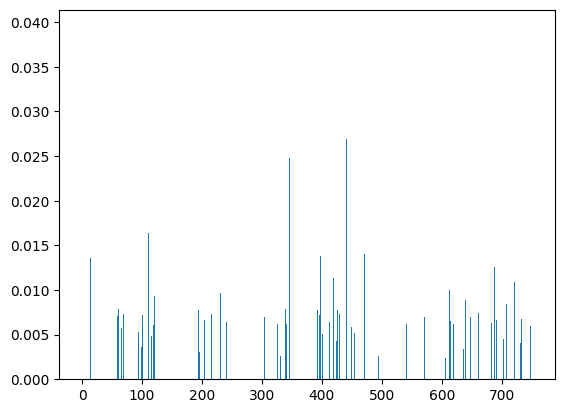

In [8]:
# feature importance
# plot
from matplotlib import pyplot
pyplot.bar(range(len(final_model.feature_importances_)), final_model.feature_importances_)
pyplot.show()

In [20]:
import numpy as np
import pickle
final_model = pickle.load(open('be700_no_selection.sav','rb'))
idx = final_model.feature_importances_.argsort()[-10:][::-1]
print(idx)

[208 620 441 346  58 133 734 111 750 292]


In [21]:
train_predict = final_model.predict(X_train)
train_acc = accuracy_score(y_train, train_predict)
print(train_acc)

0.9718076285240465


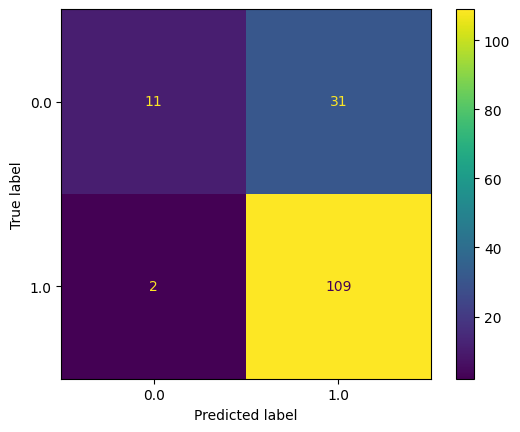

0.8685258964143425
0.3903360258501626


In [11]:
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

f1score = f1_score(Yt, yhat)
mccscore = matthews_corrcoef(Yt,yhat)

cm = confusion_matrix(Yt, yhat, labels=final_model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=final_model.classes_)
disp.plot()
pyplot.show()

print(f1score)
print(mccscore)